In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
import numpy as np
import torch
import math
import pickle

In [5]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Concatenate
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import MinMaxScaler

In [6]:
ROA = '/content/drive/MyDrive/df_ROA.pkl'
ROC = '/content/drive/MyDrive/df_ROC.pkl'
RGA = '/content/drive/MyDrive/df_RGA.pkl'
RGC = '/content/drive/MyDrive/df_RGC.pkl'
with open(ROA, 'rb') as file:
    dataROA = pickle.load(file)
with open(ROC, 'rb') as file:
    dataROC = pickle.load(file)
with open(RGA, 'rb') as file:
    dataRGA = pickle.load(file)
with open(RGC, 'rb') as file:
    dataRGC = pickle.load(file)

In [39]:
dataROA = dataROA.drop(dataROA[dataROA['Indice_VIS'] == '-'].index)
dataROC = dataROC.drop(dataROC[dataROC['Indice_VIS'] == '-'].index)
dataRGA = dataRGA.drop(dataRGA[dataRGA['Indice_VIS'] == '-'].index)
dataRGC = dataRGC.drop(dataRGC[dataRGC['Indice_VIS'] == '-'].index)

dataROA = dataROA.drop(dataROA[dataROA['Indice_VEST'] == '-'].index)
dataROC = dataROC.drop(dataROC[dataROC['Indice_VEST'] == '-'].index)
dataRGA = dataRGA.drop(dataRGA[dataRGA['Indice_VEST'] == '-'].index)
dataRGC = dataRGC.drop(dataRGC[dataRGC['Indice_VEST'] == '-'].index)

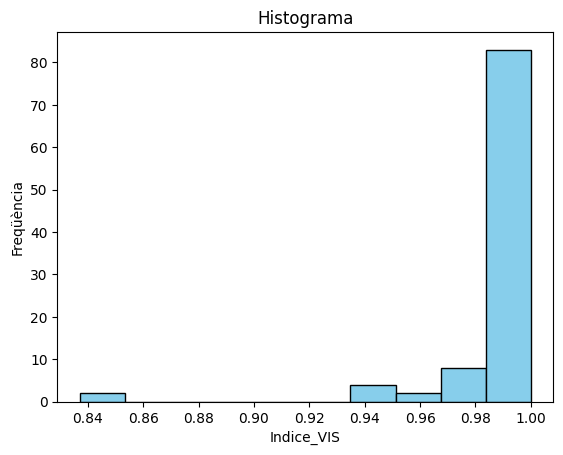

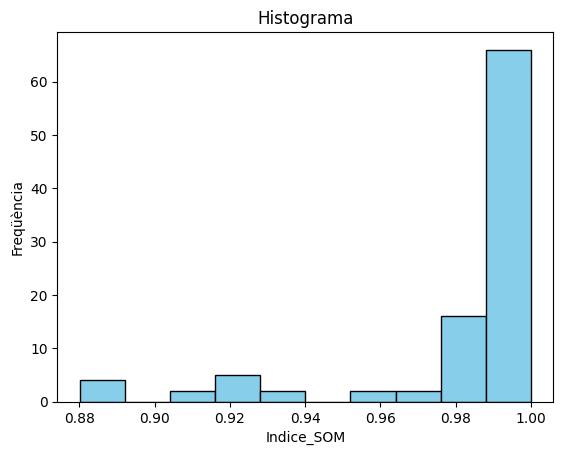

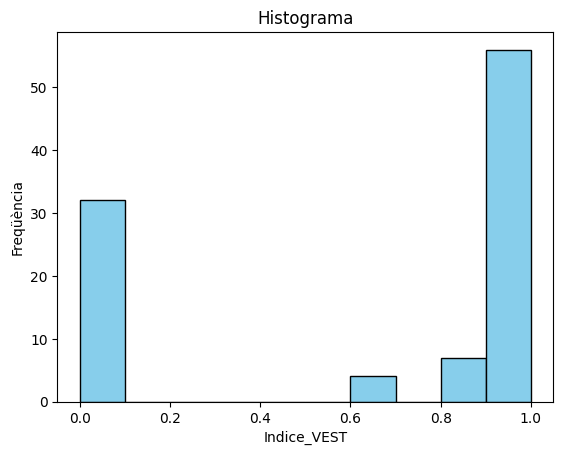

In [41]:
Índex_VIS = dataROA['Indice_VIS'].astype(float)/100
Índex_SOM = dataROA['Indice_SOM'].astype(float)/100
Índex_VEST = dataROA['Indice_VEST'].astype(float)/100

pyplot.hist(Índex_VIS, color='skyblue', edgecolor='black')
pyplot.title('Histograma')
pyplot.xlabel('Indice_VIS')
pyplot.ylabel('Freqüència')
pyplot.show()

pyplot.hist(Índex_SOM, color='skyblue', edgecolor='black')
pyplot.title('Histograma')
pyplot.xlabel('Indice_SOM')
pyplot.ylabel('Freqüència')
pyplot.show()

pyplot.hist(Índex_VEST, color='skyblue', edgecolor='black')
pyplot.title('Histograma')
pyplot.xlabel('Indice_VEST')
pyplot.ylabel('Freqüència')
pyplot.show()

In [47]:
X = dataROA.drop(columns = ['id','action','rep','time','Indice_VIS','Indice_VEST','Indice_SOM'])
X = X.reset_index(drop=True)
X.shape

(99, 12)

In [10]:
X.columns

Index(['acelerometro_x', 'acelerometro_y', 'acelerometro_z', 'giroscopo_x',
       'giroscopo_y', 'giroscopo_z', 'compass_x', 'compass_y', 'compass_z',
       'gravity_vector_x', 'gravity_vector_y', 'gravity_vector_z'],
      dtype='object')

<ipython-input-43-972f2158ddd7>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)


KeyError: ignored

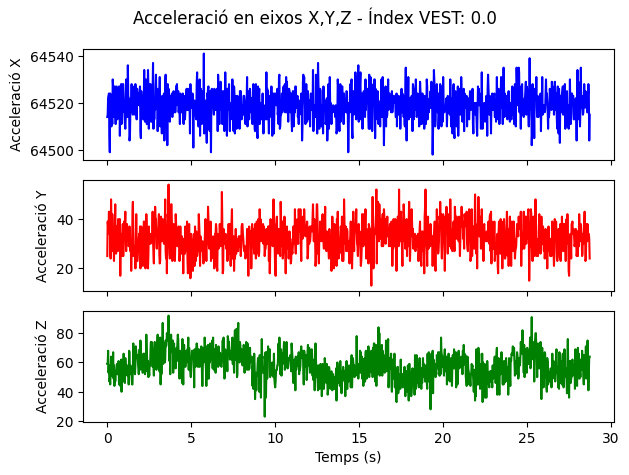

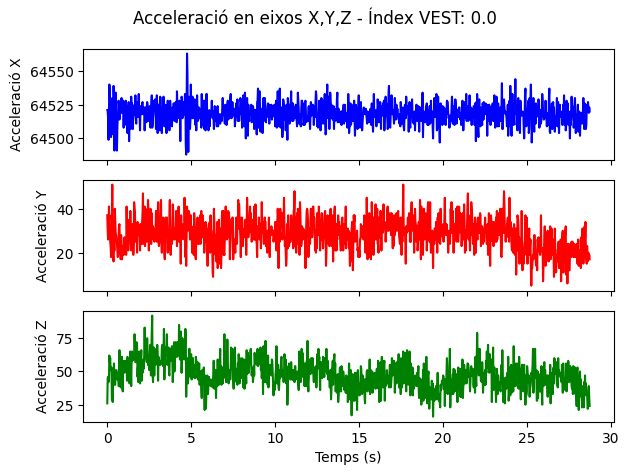

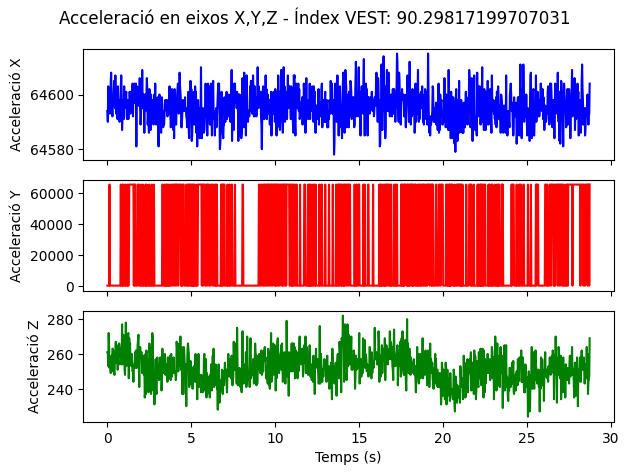

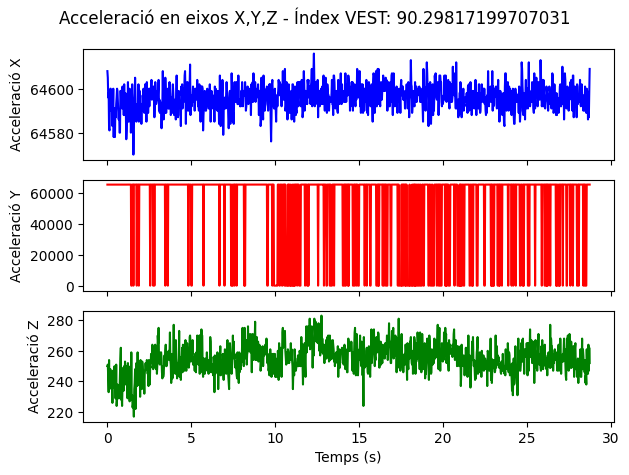

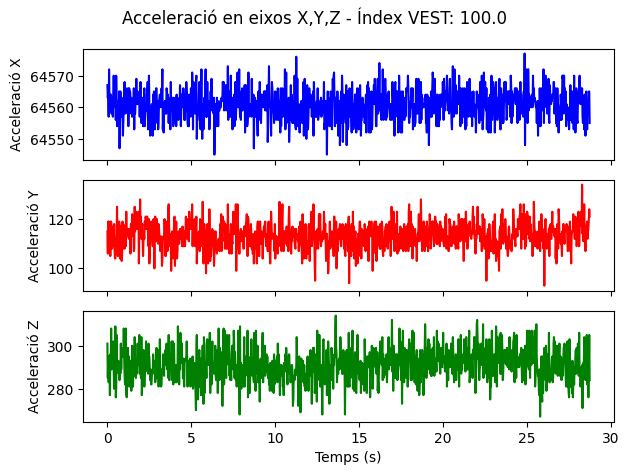

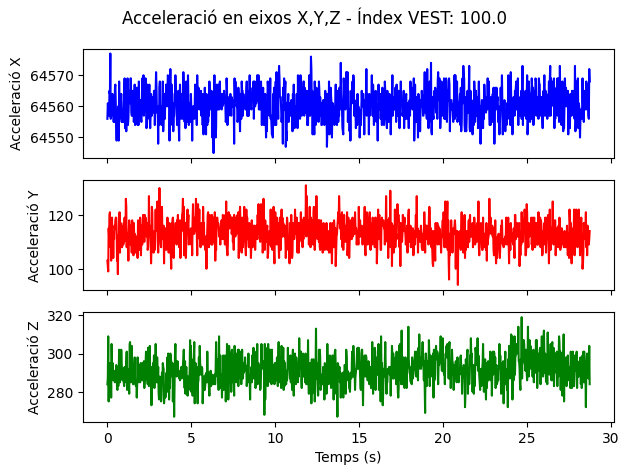

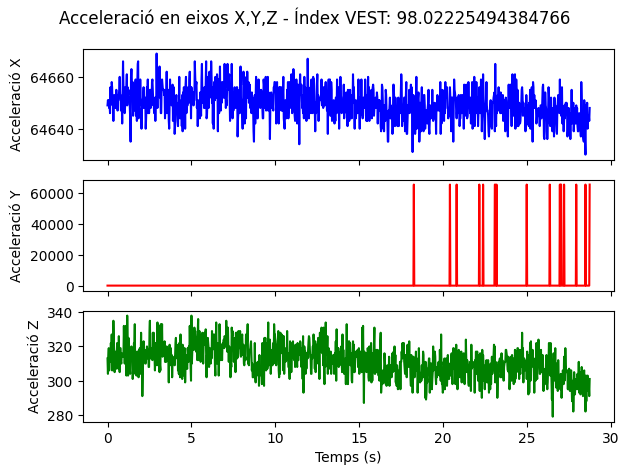

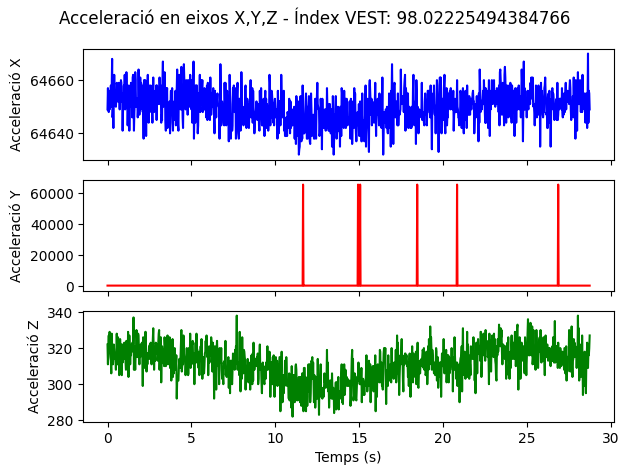

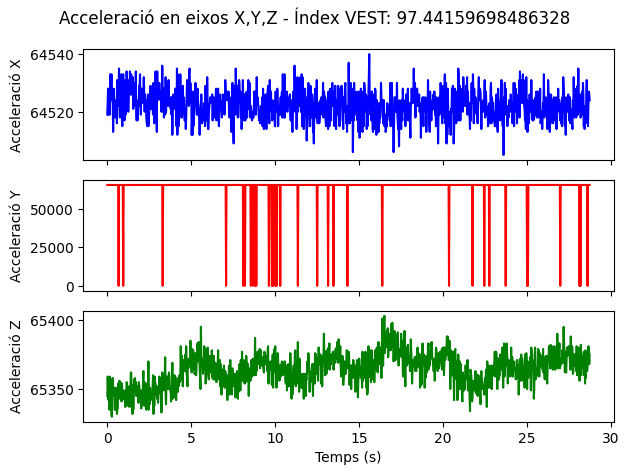

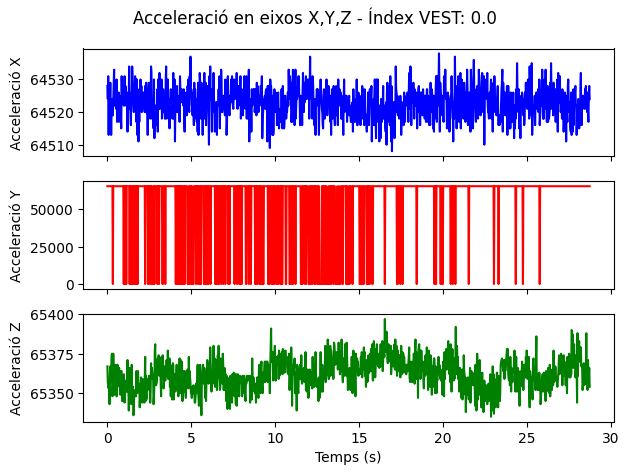

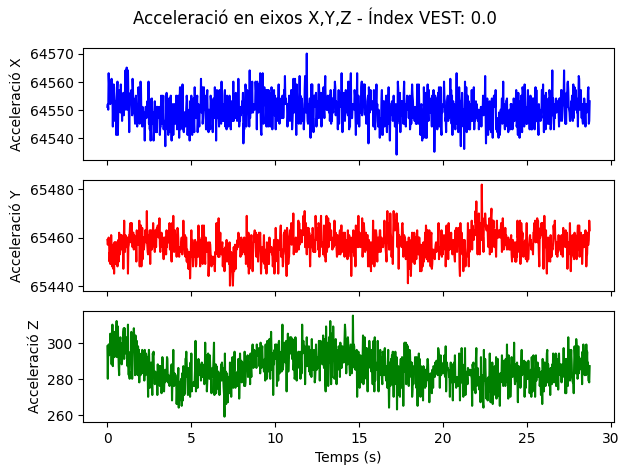

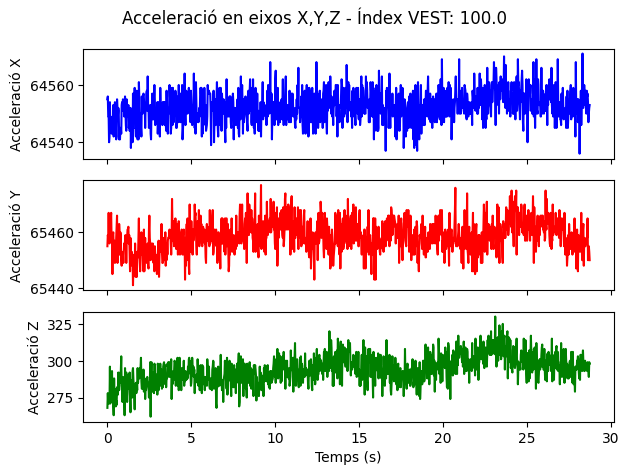

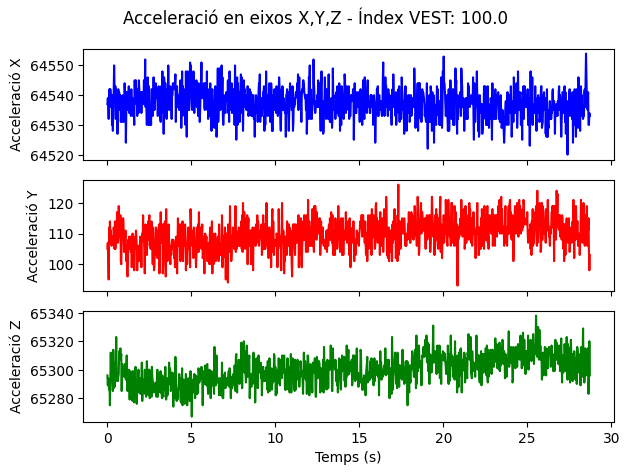

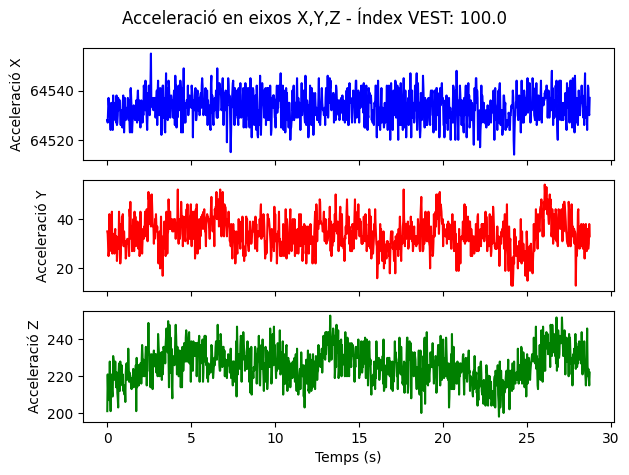

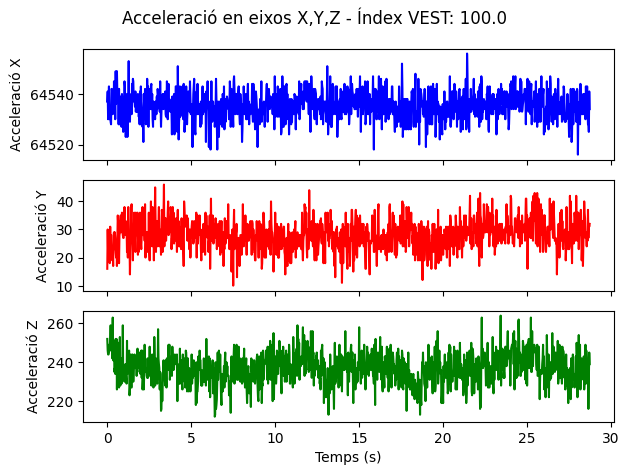

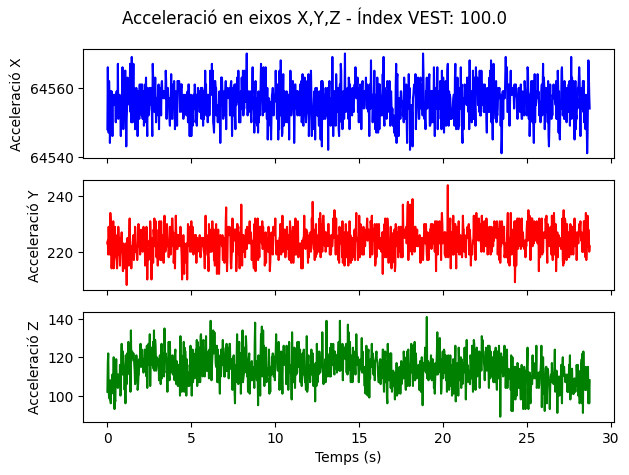

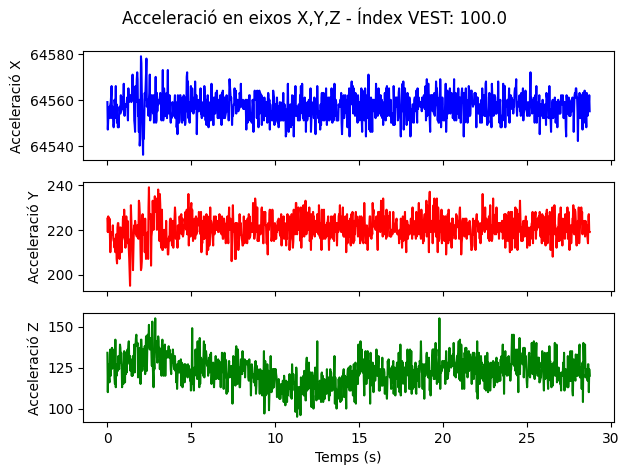

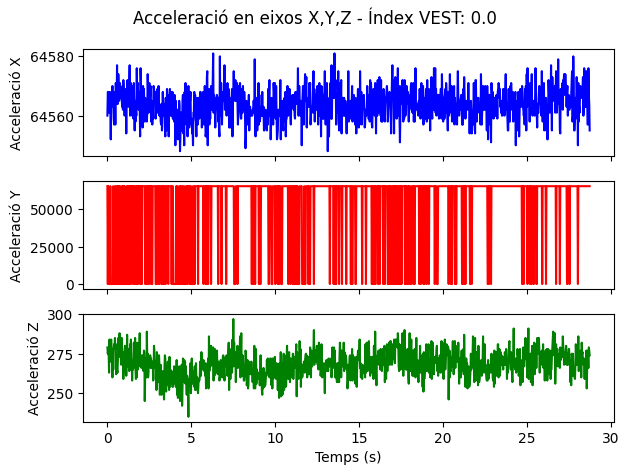

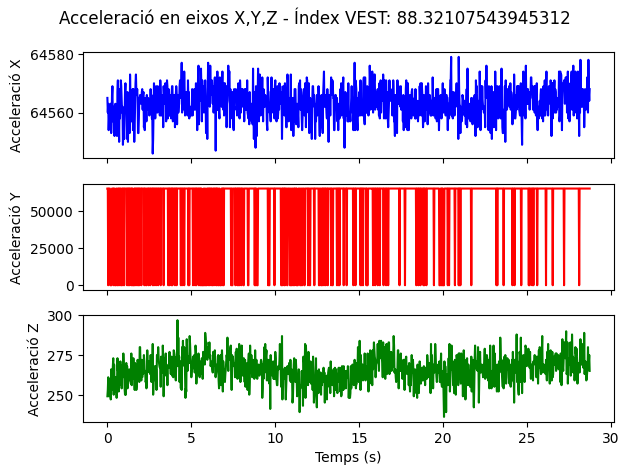

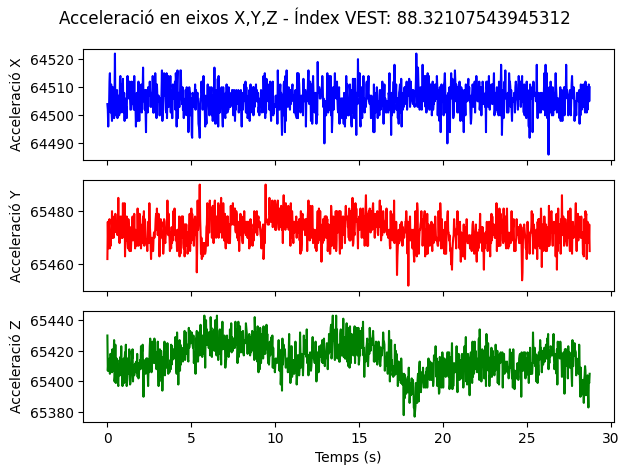

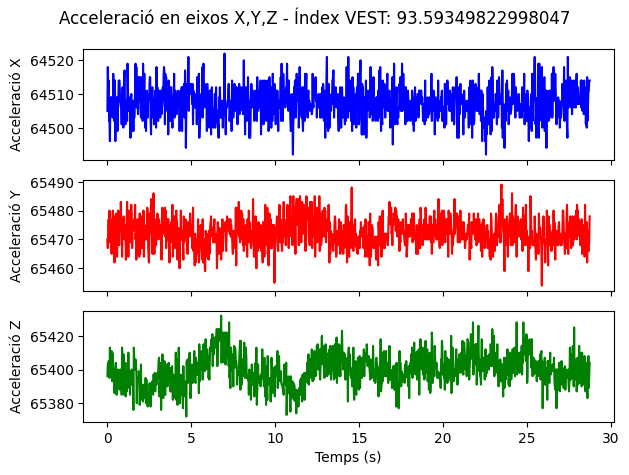

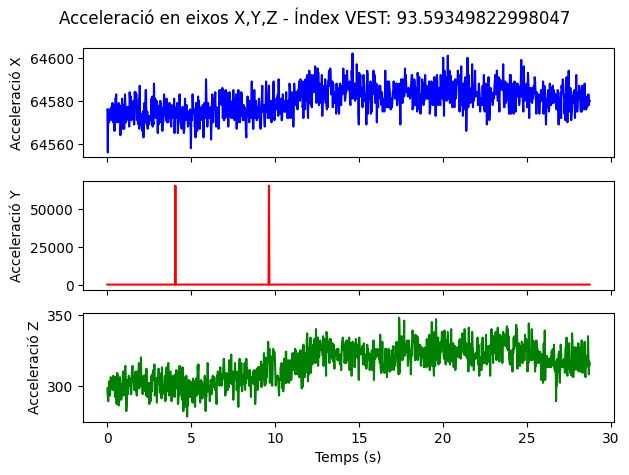

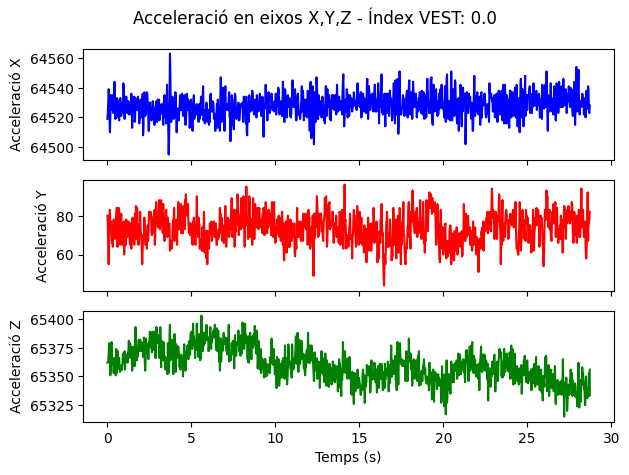

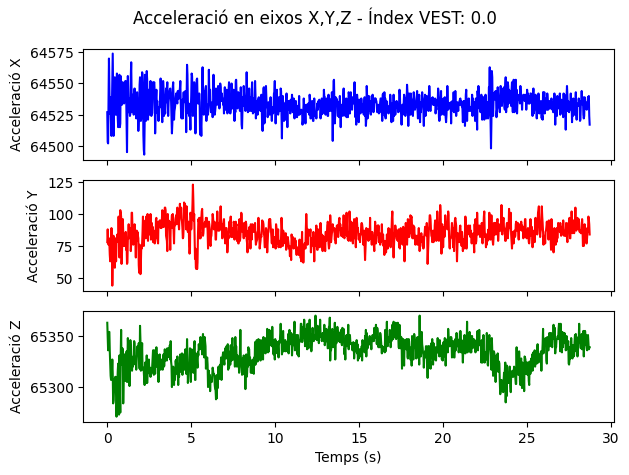

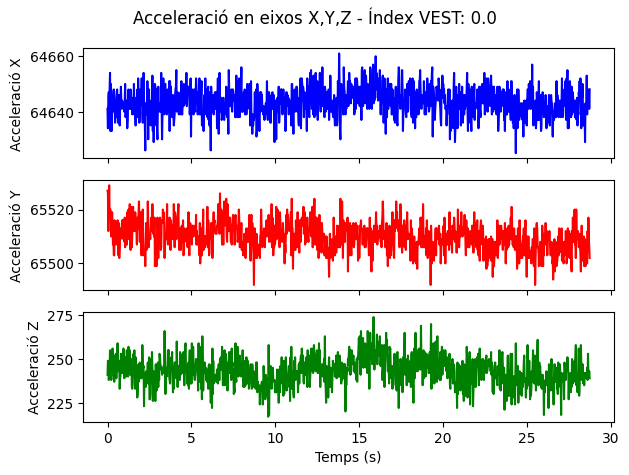

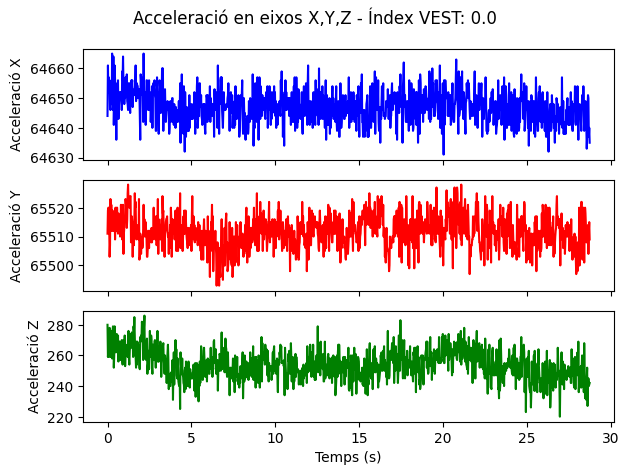

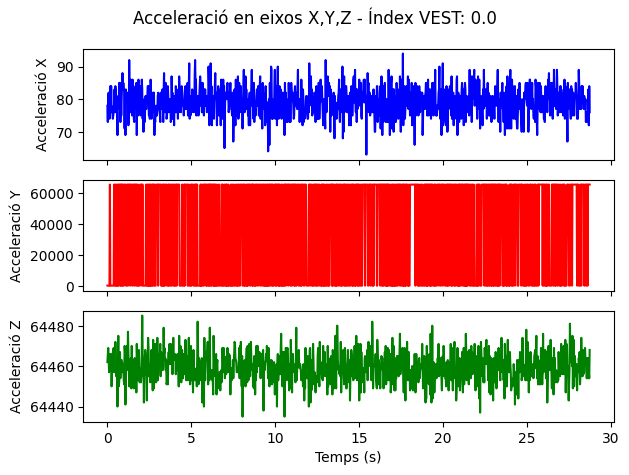

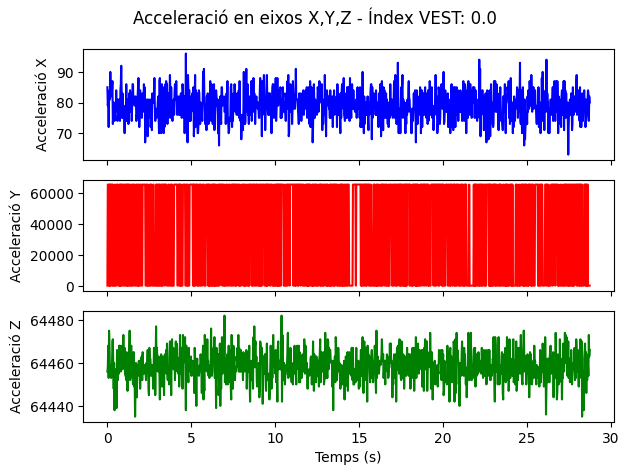

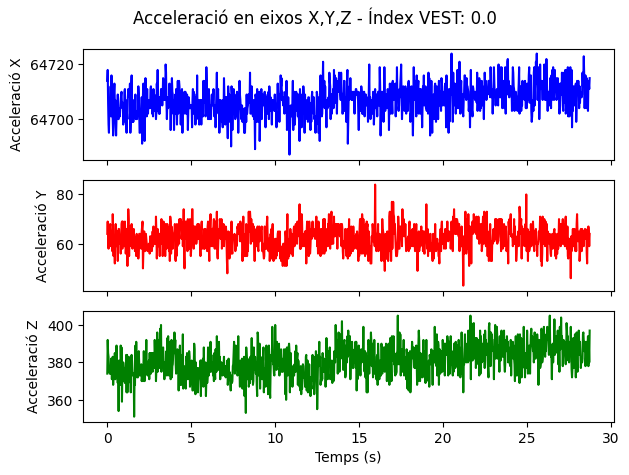

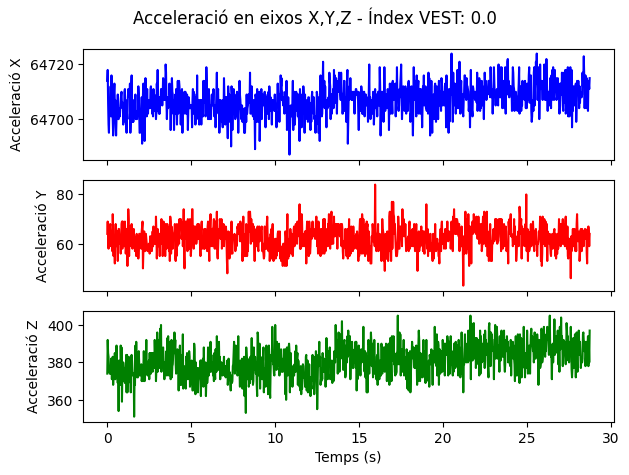

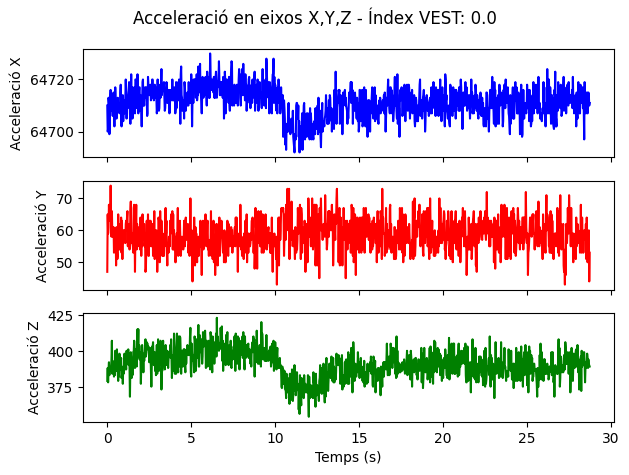

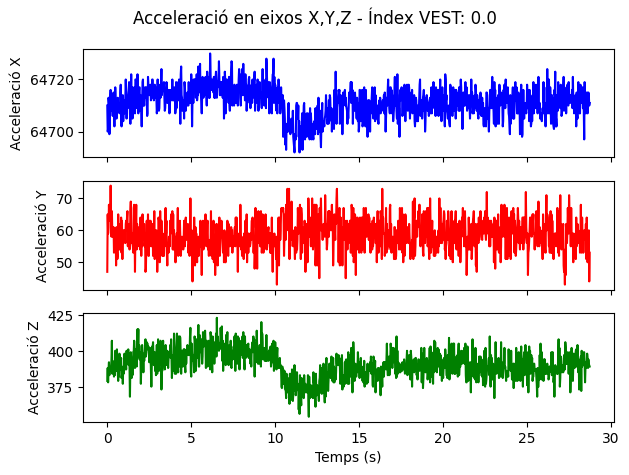

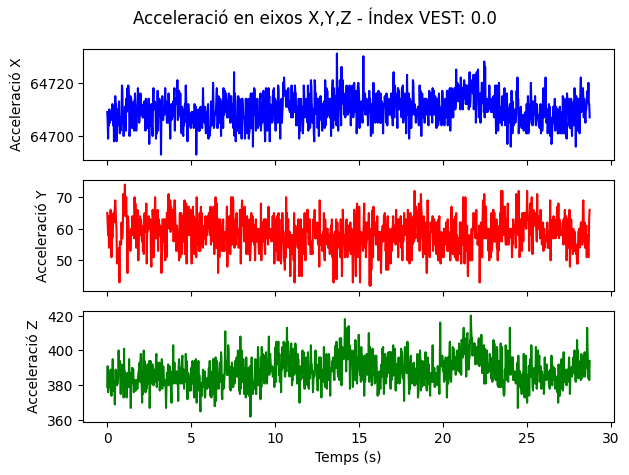

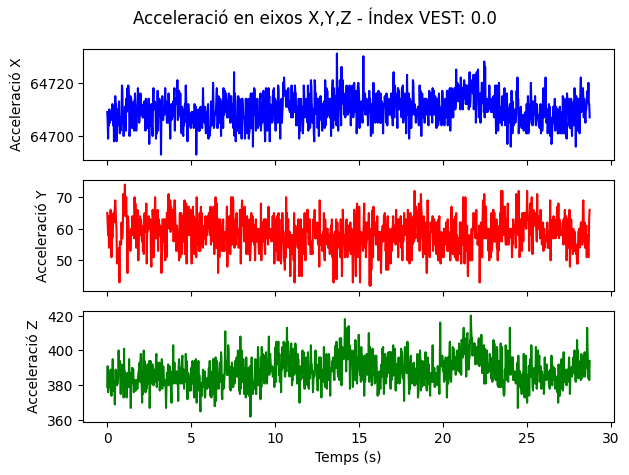

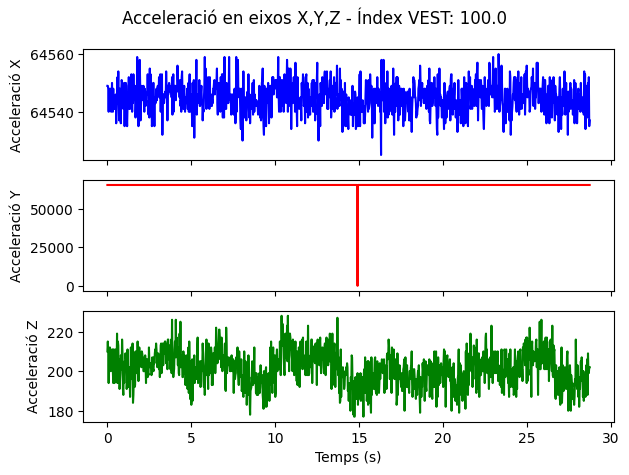

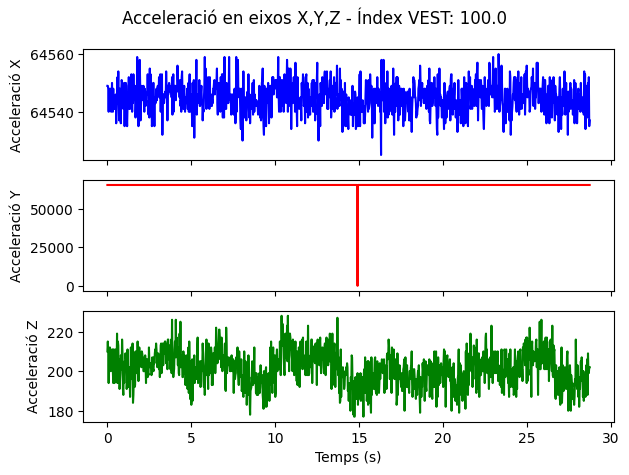

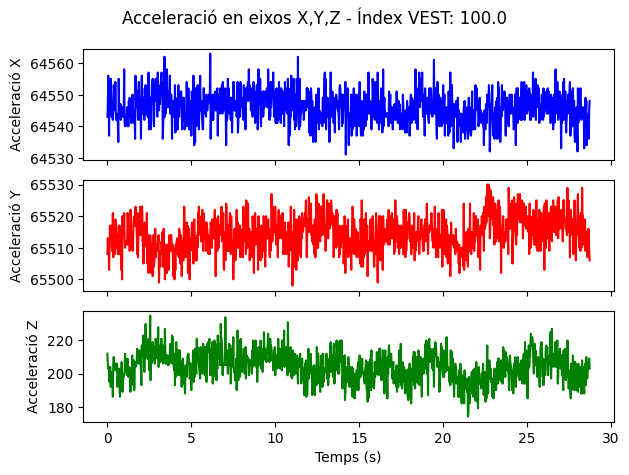

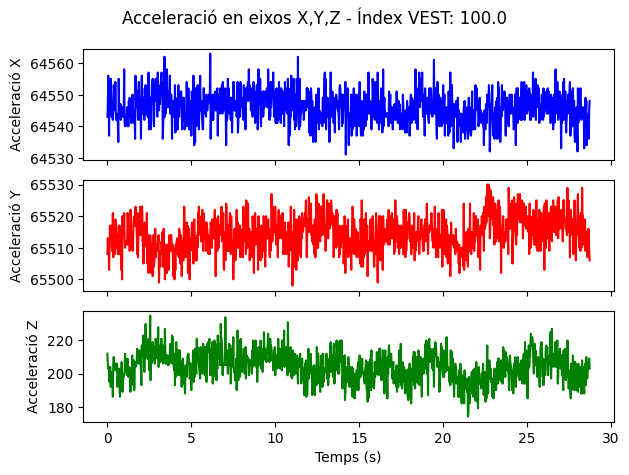

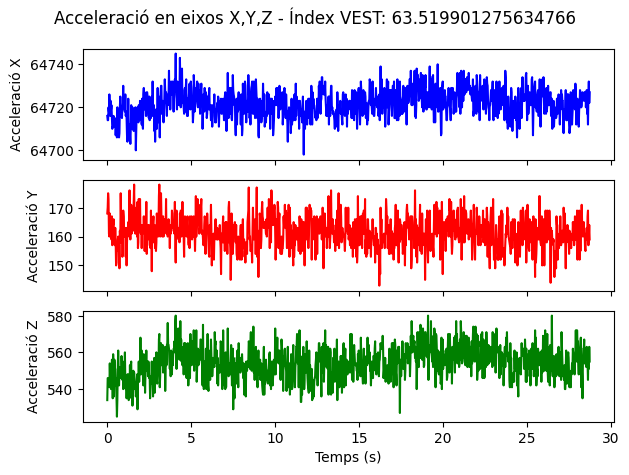

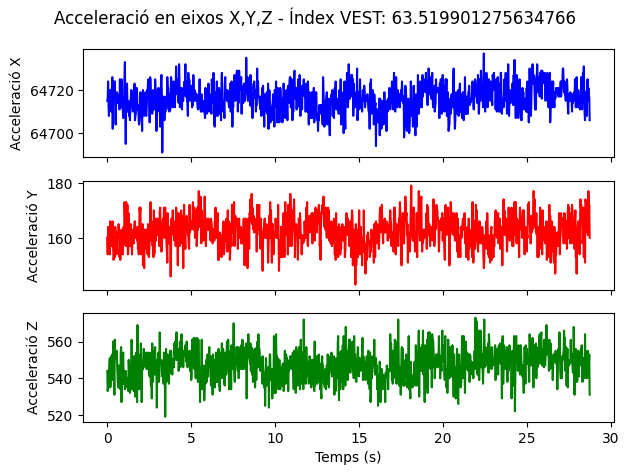

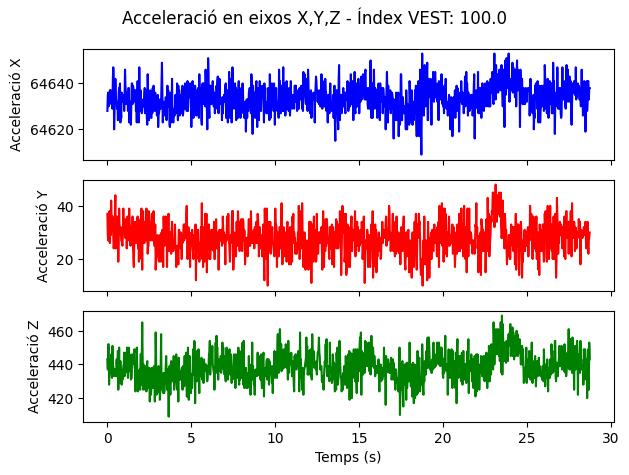

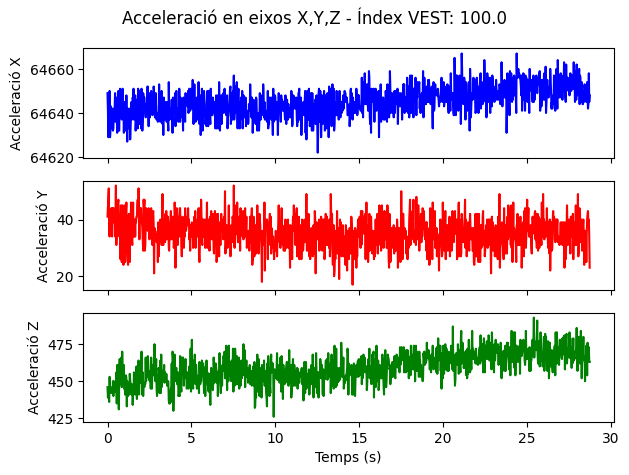

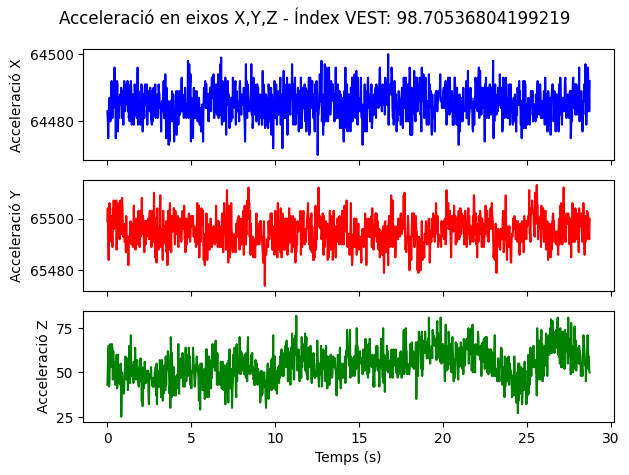

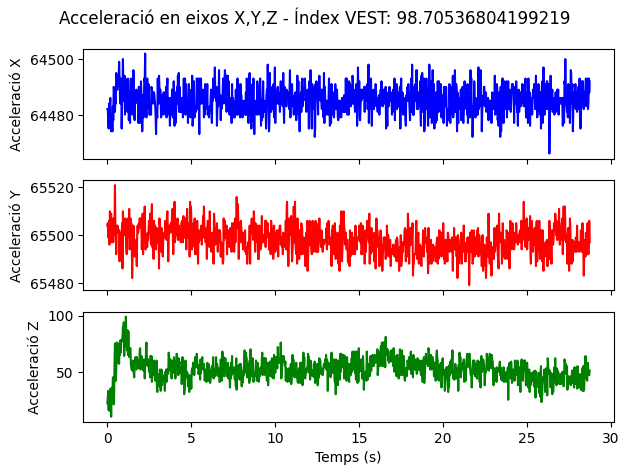

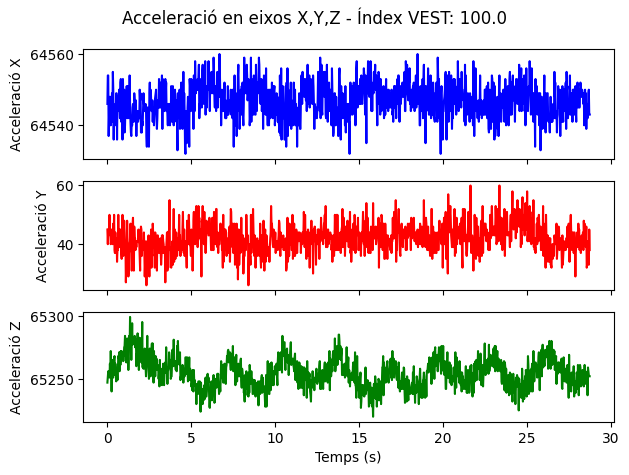

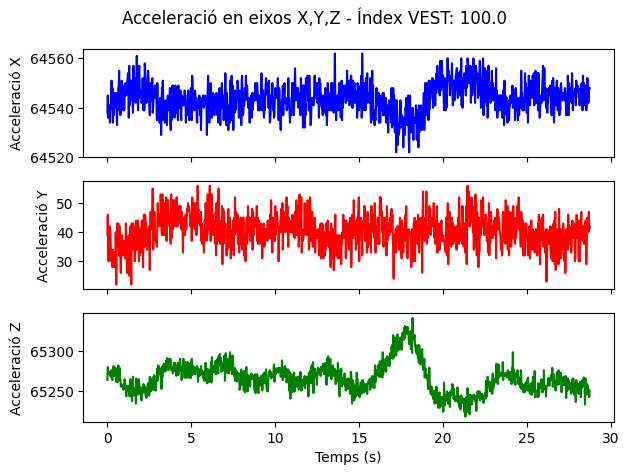

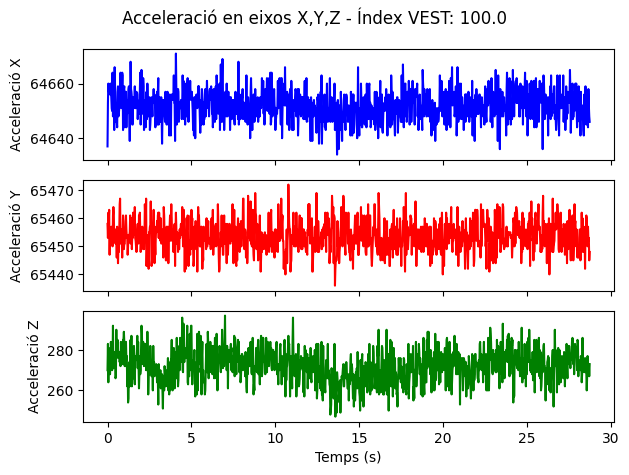

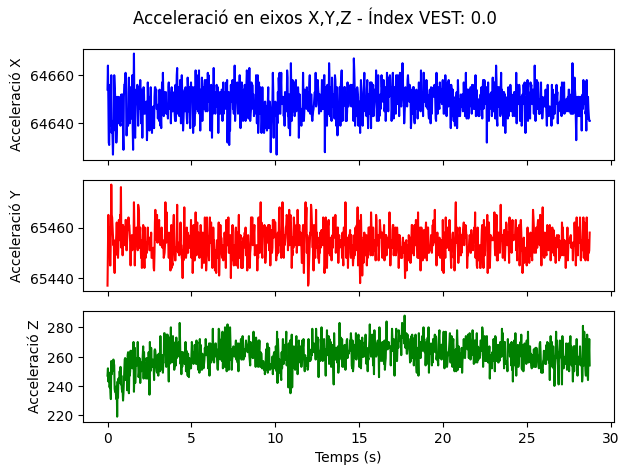

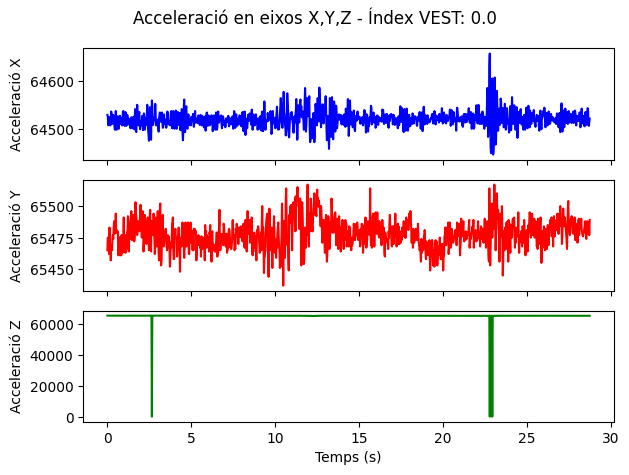

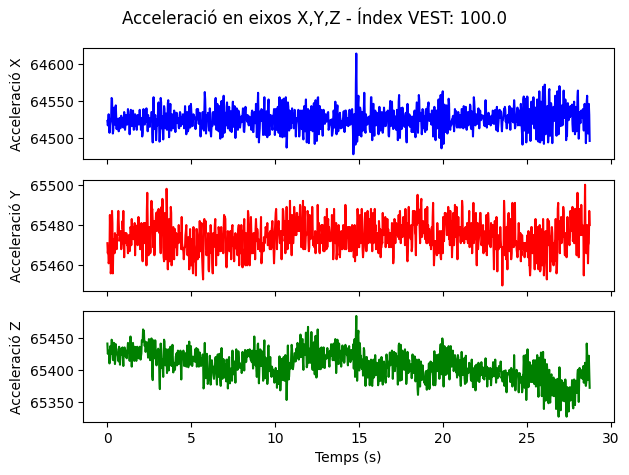

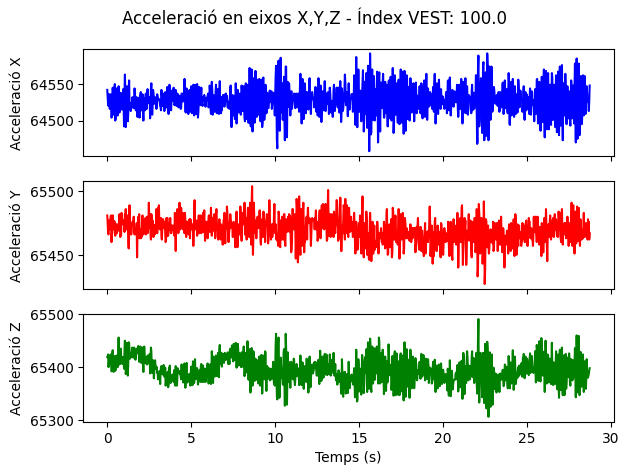

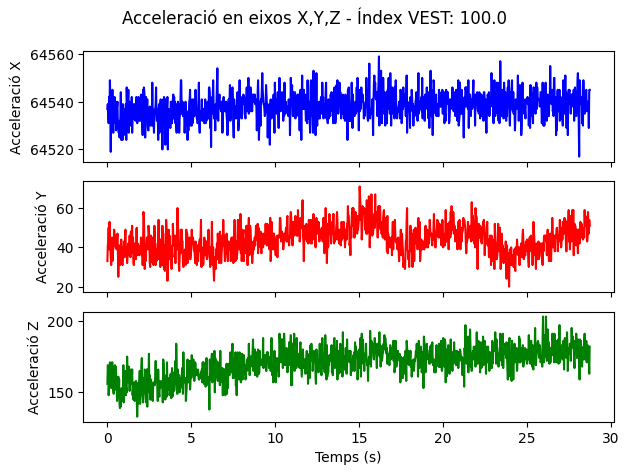

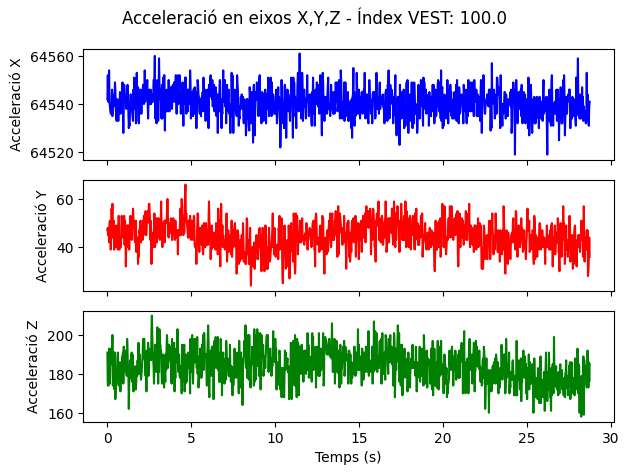

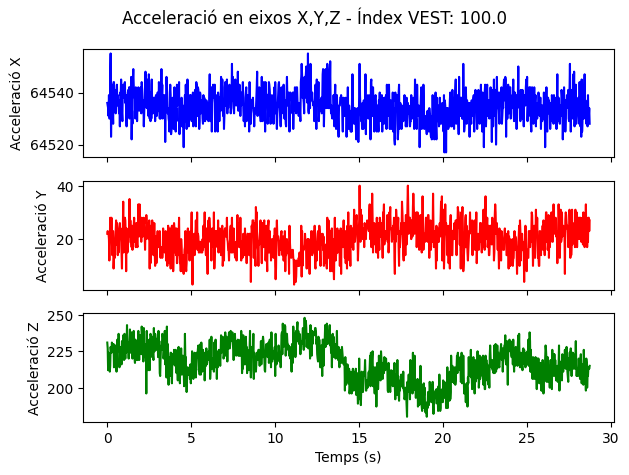

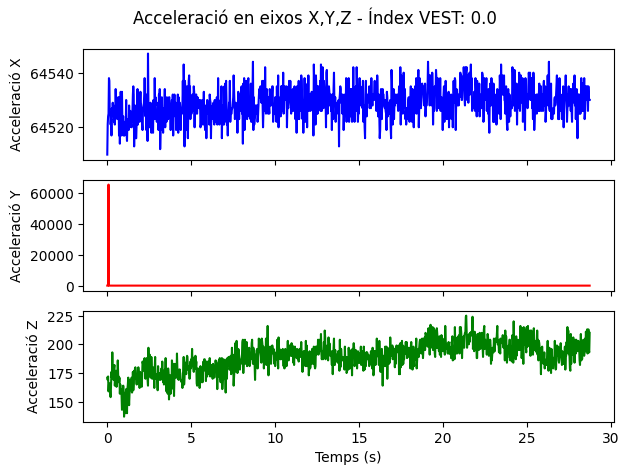

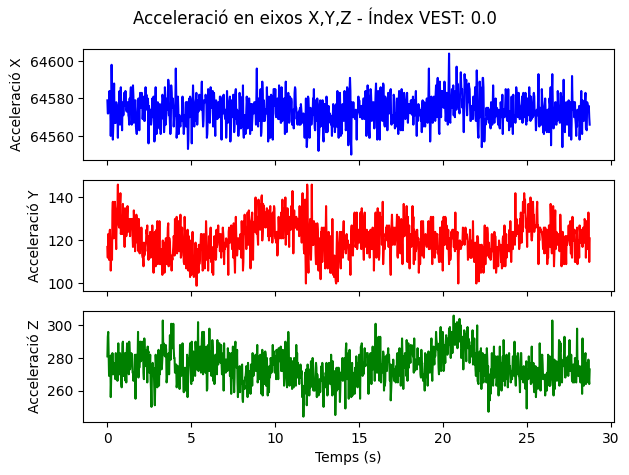

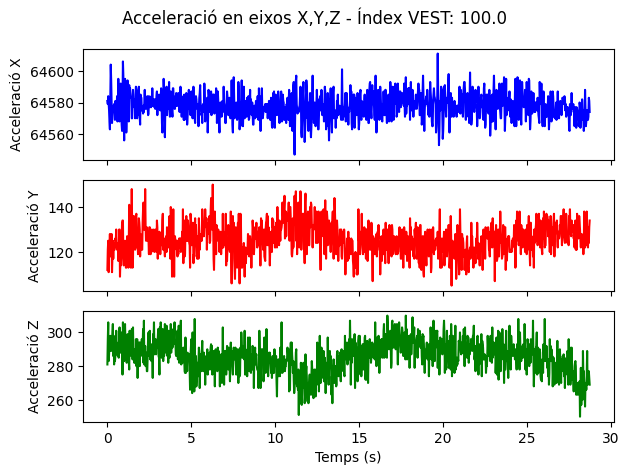

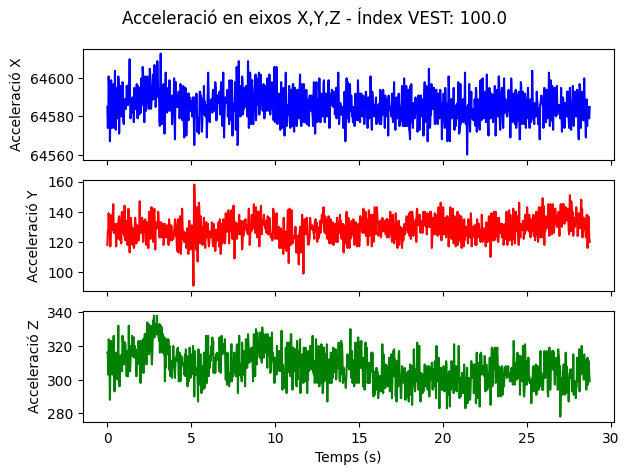

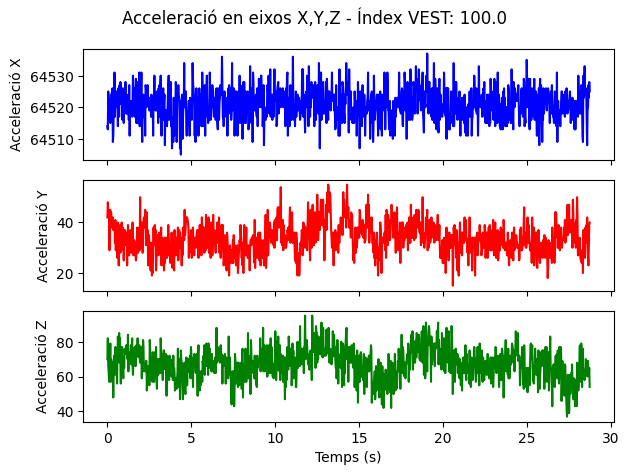

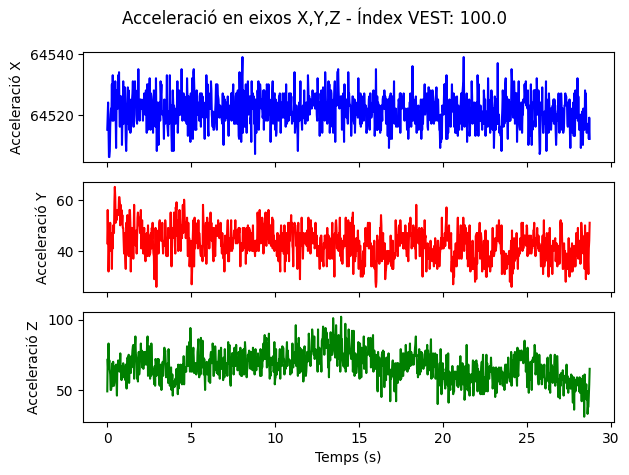

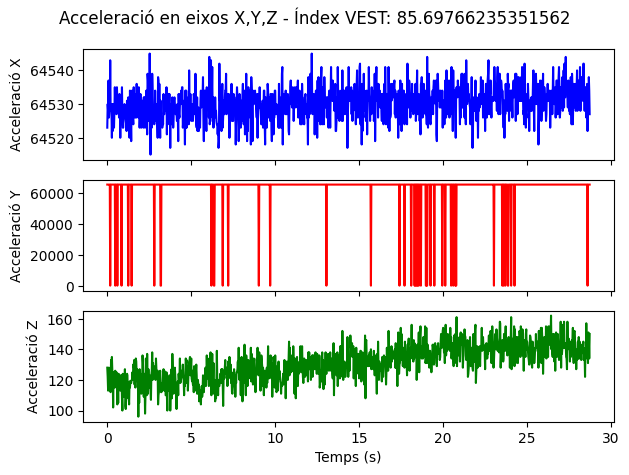

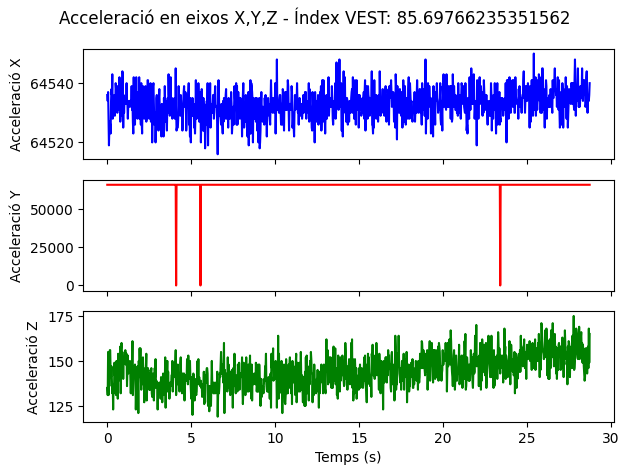

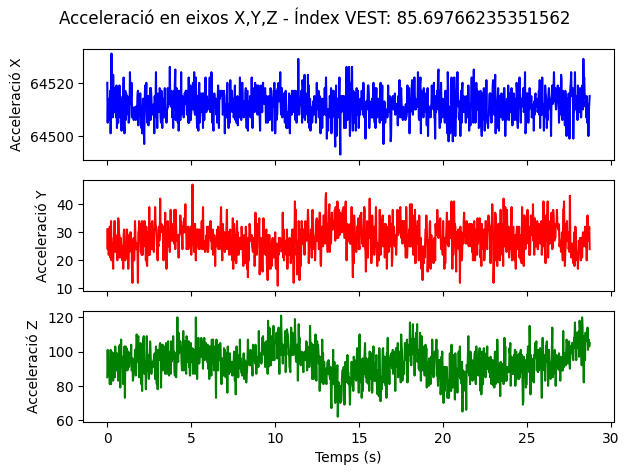

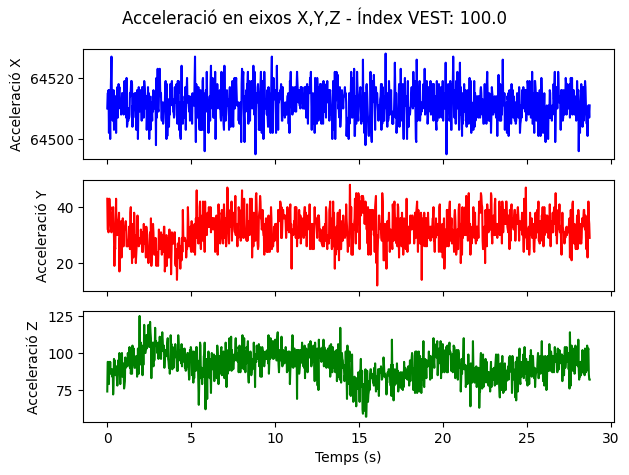

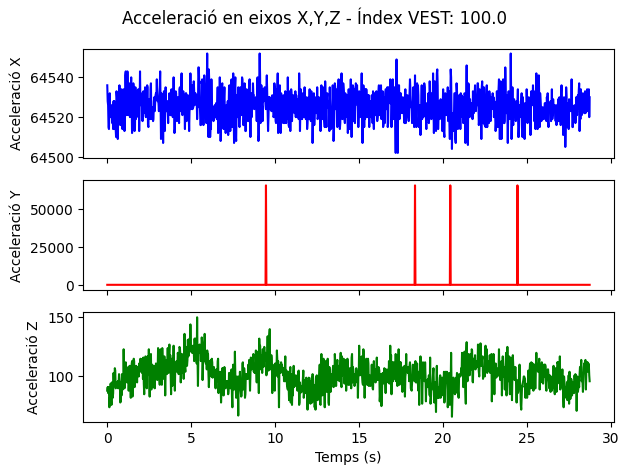

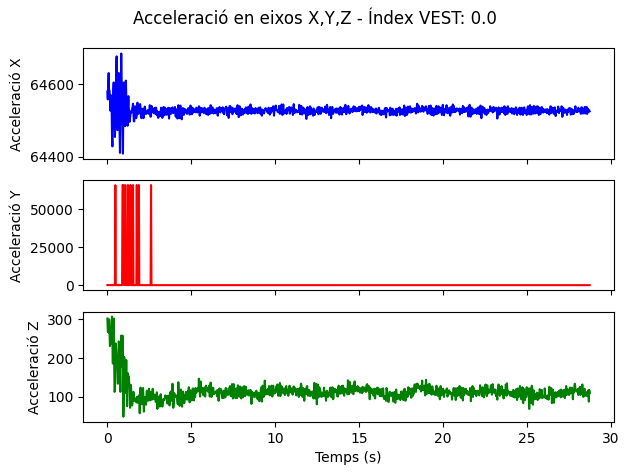

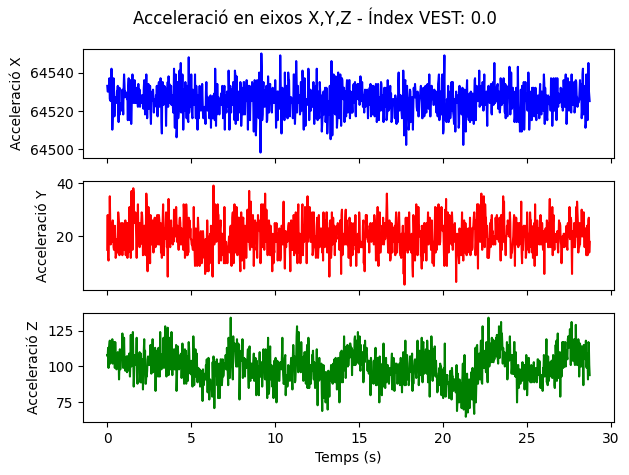

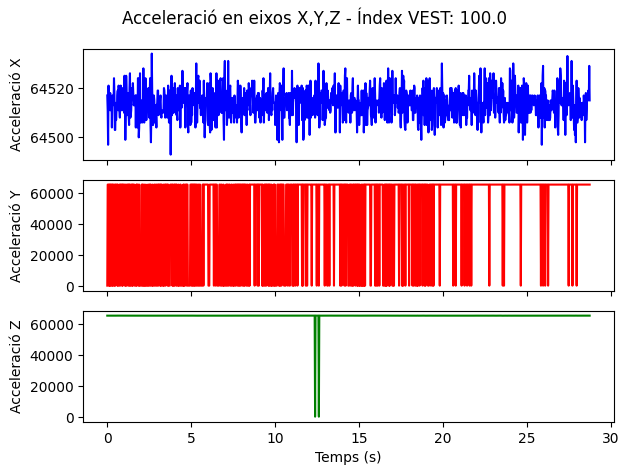

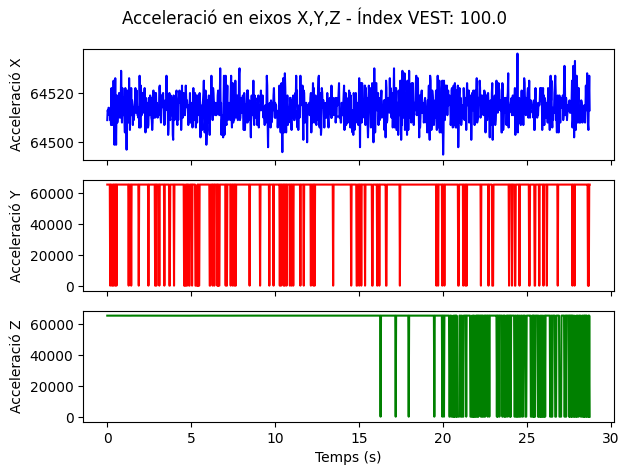

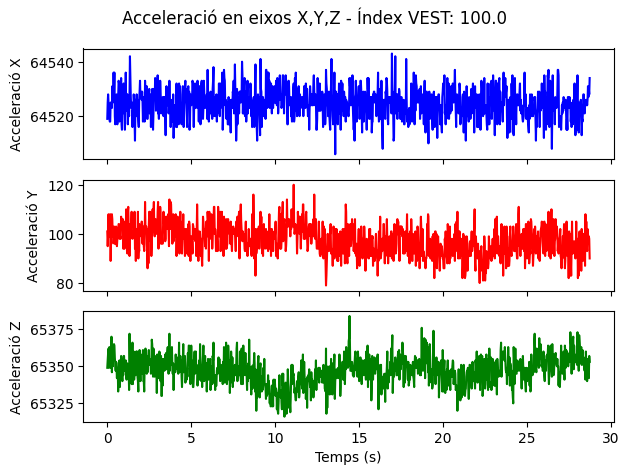

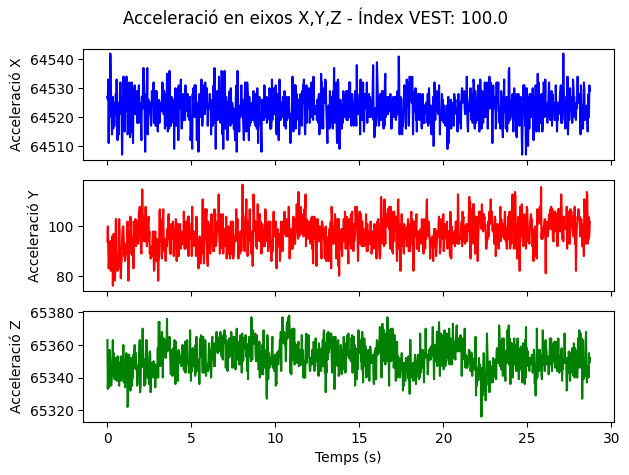

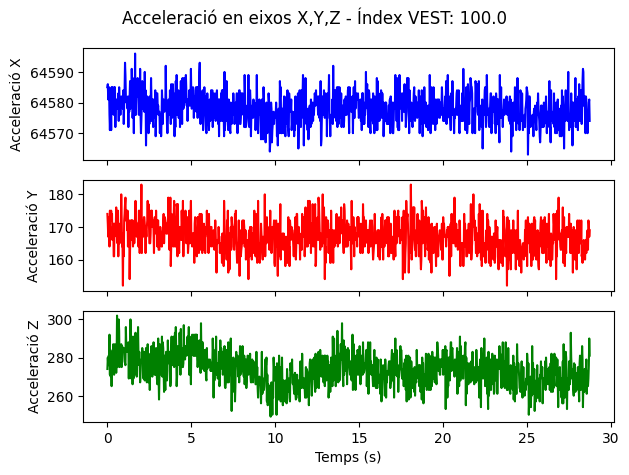

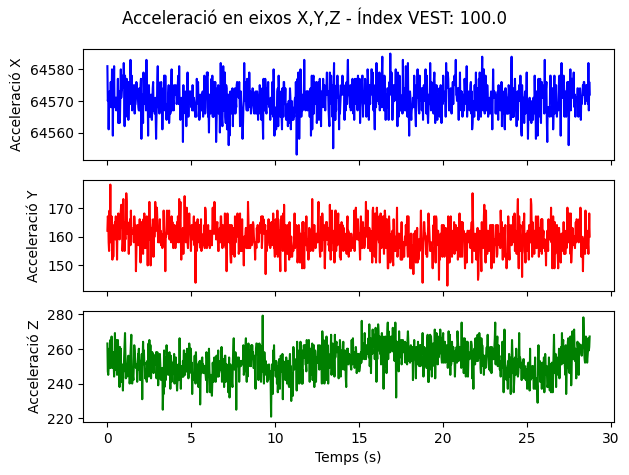

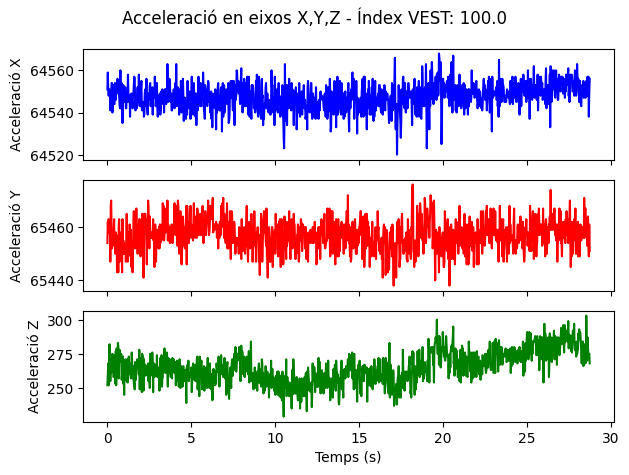

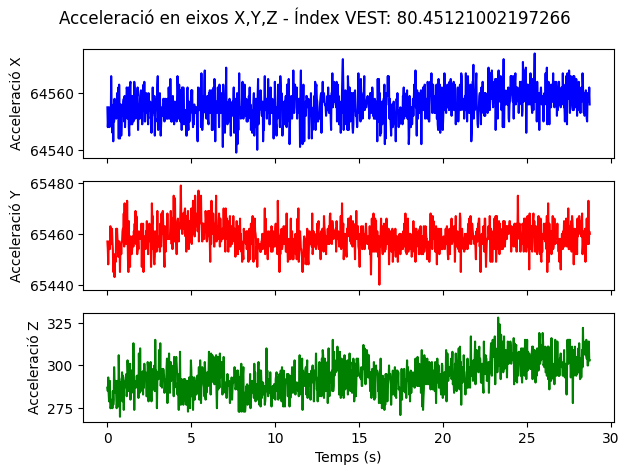

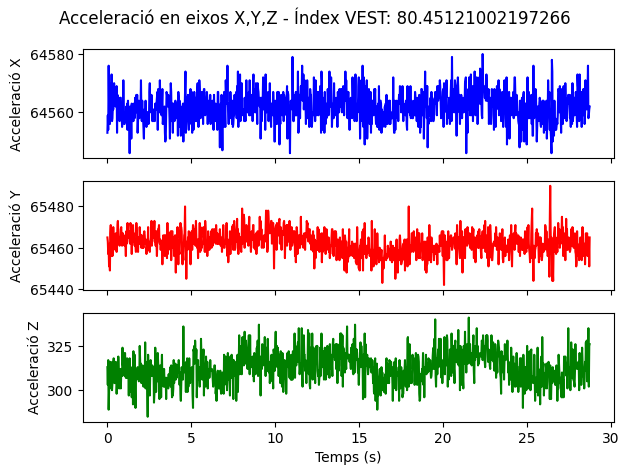

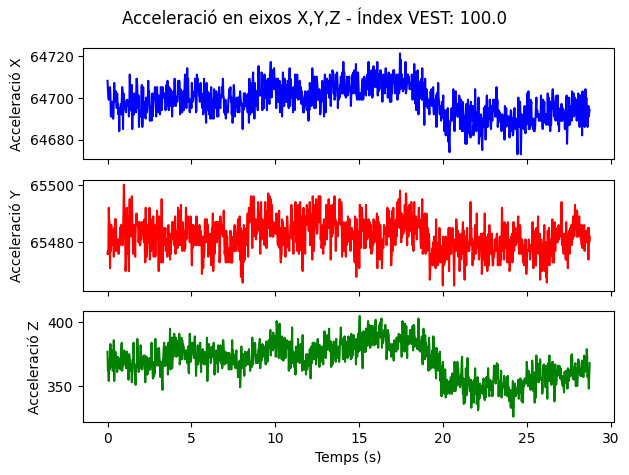

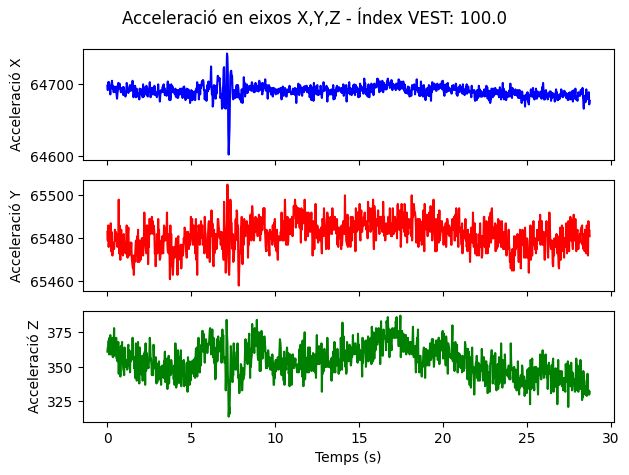

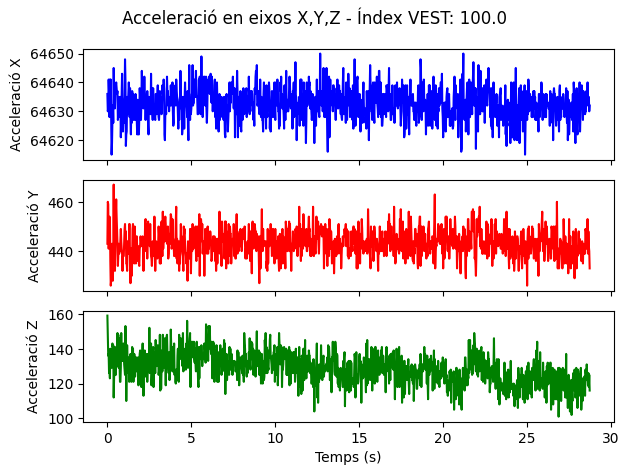

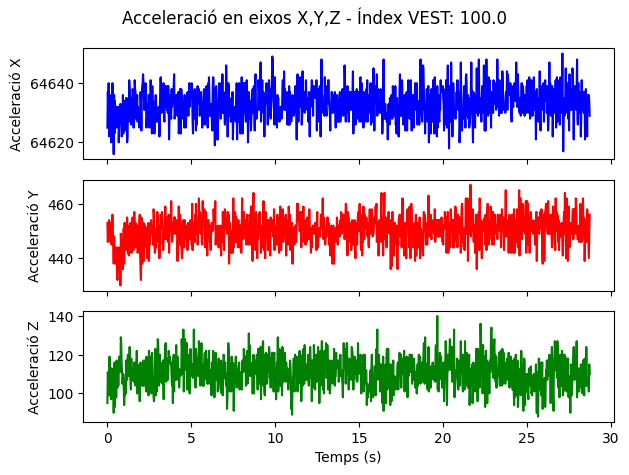

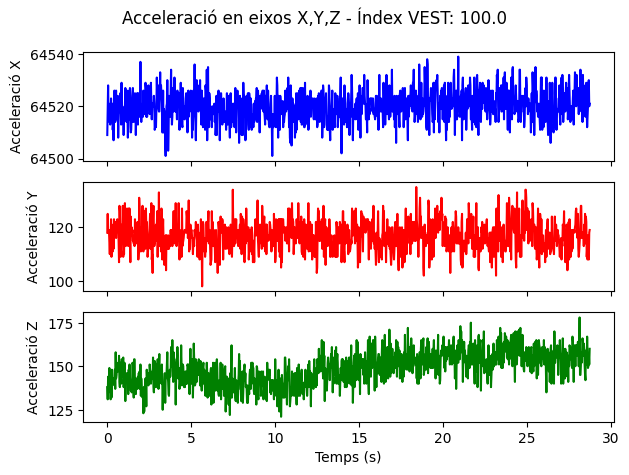

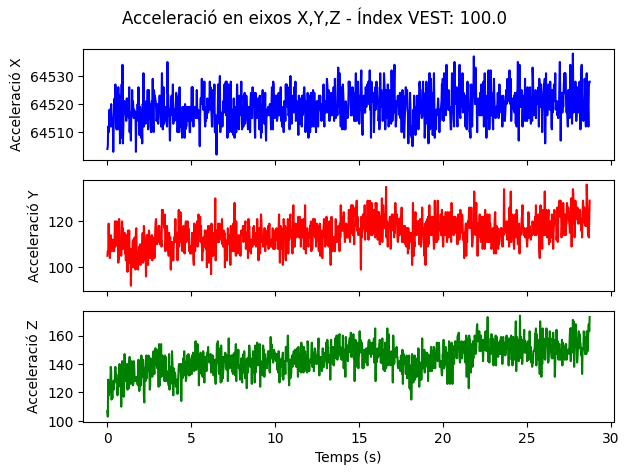

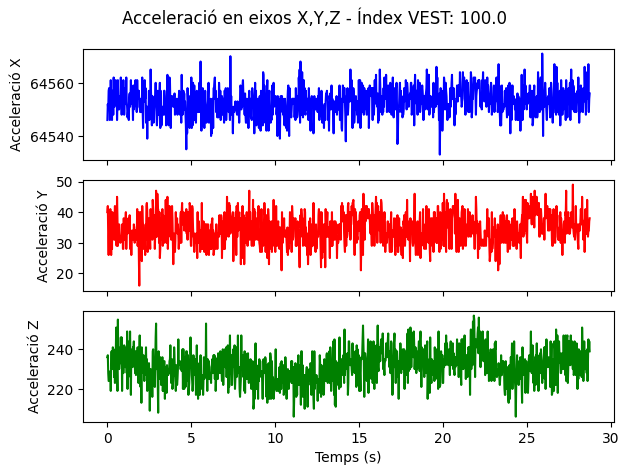

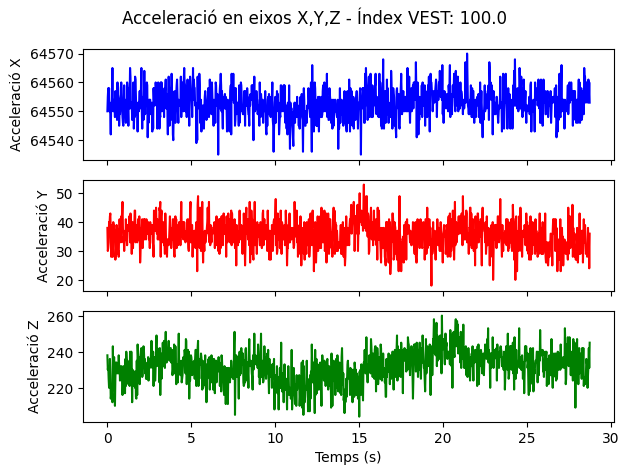

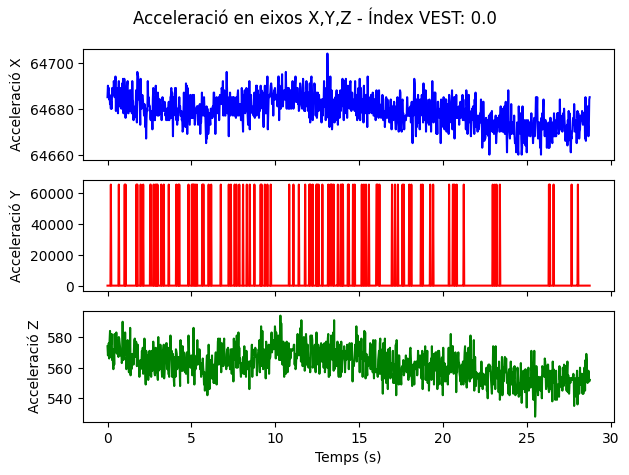

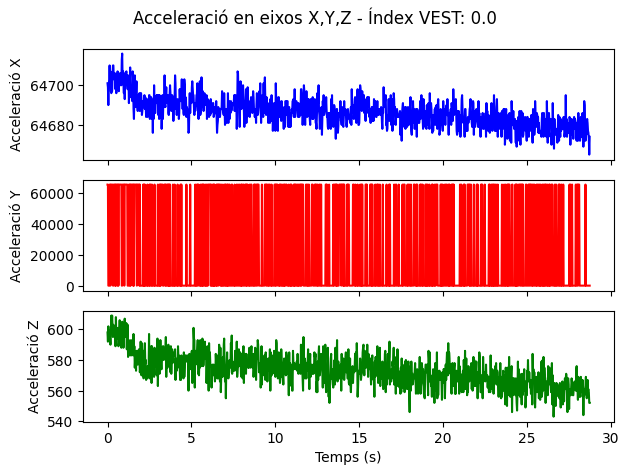

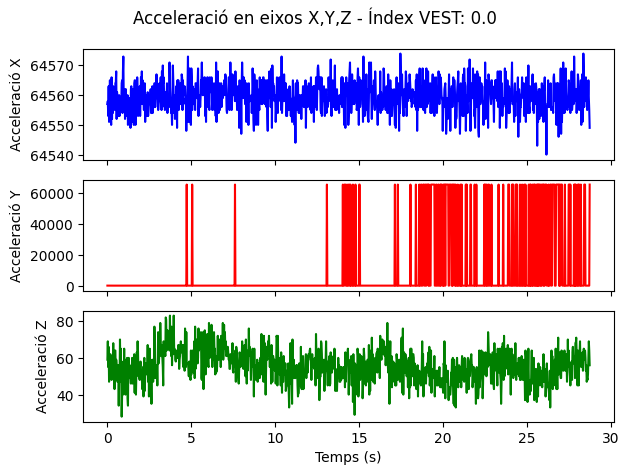

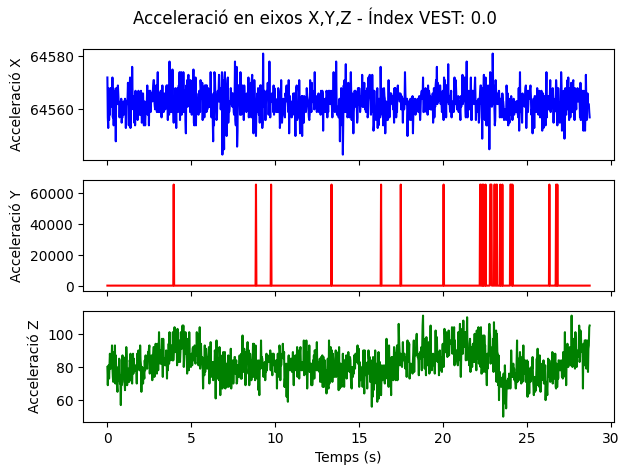

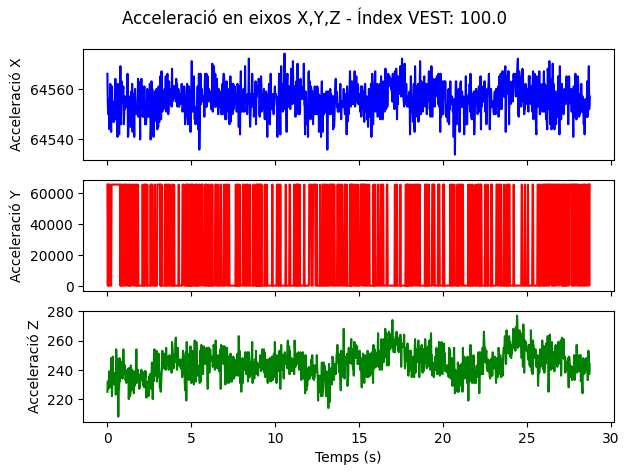

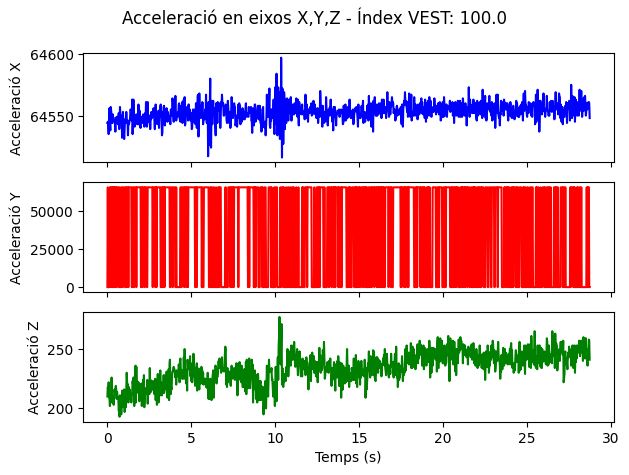

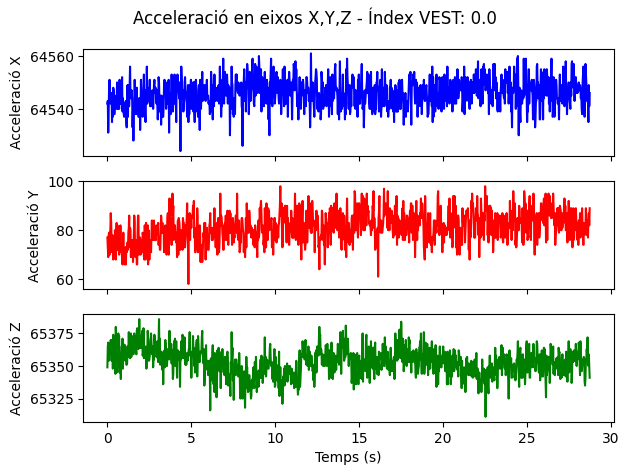

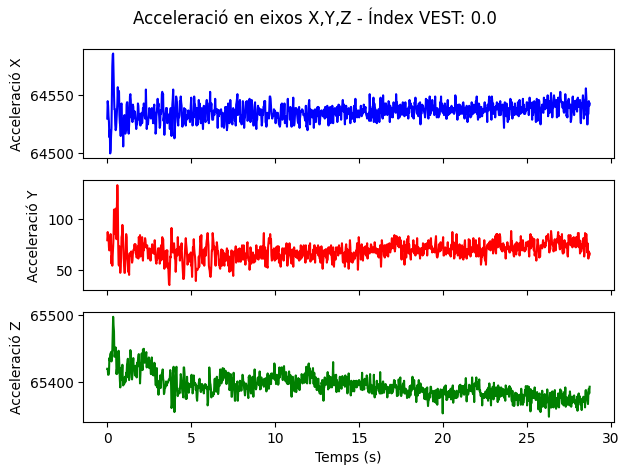

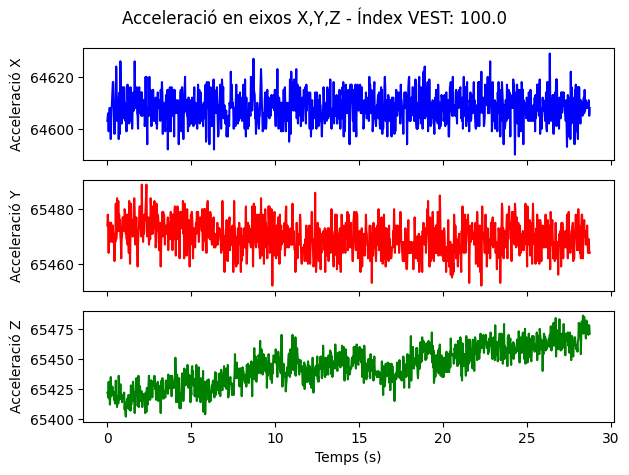

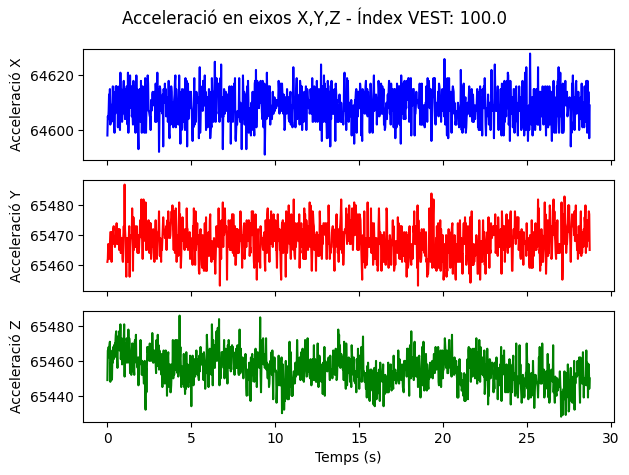

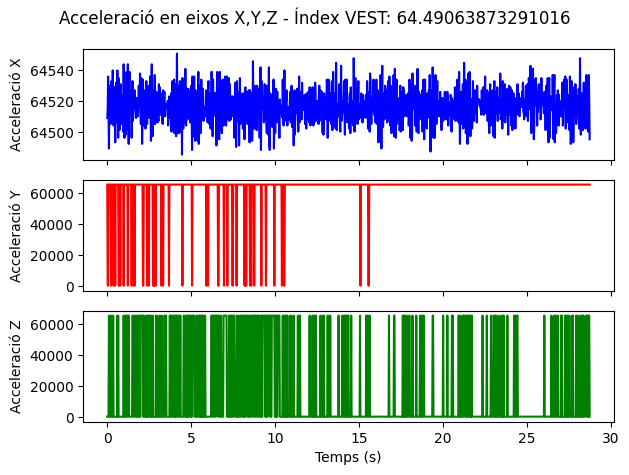

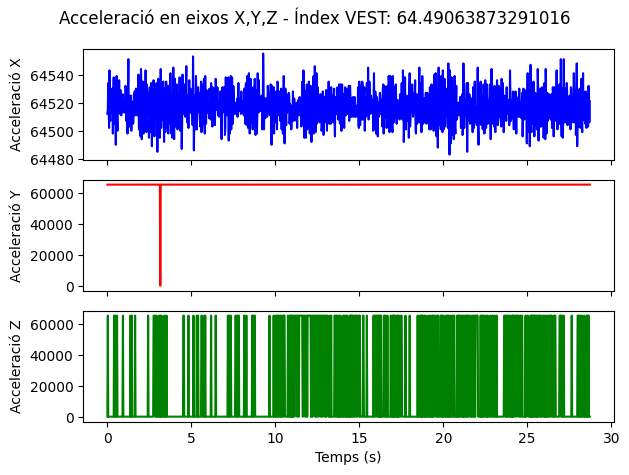

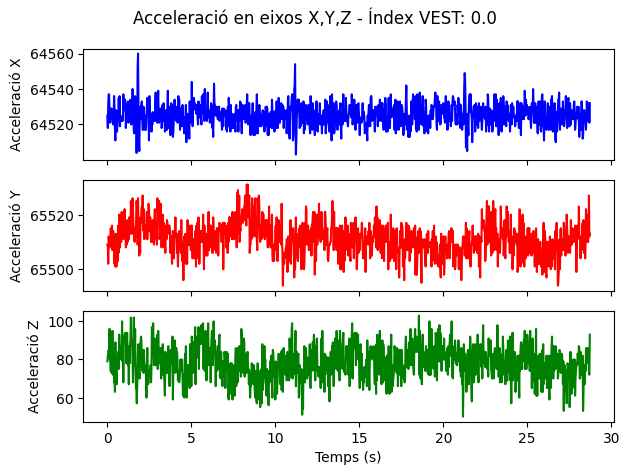

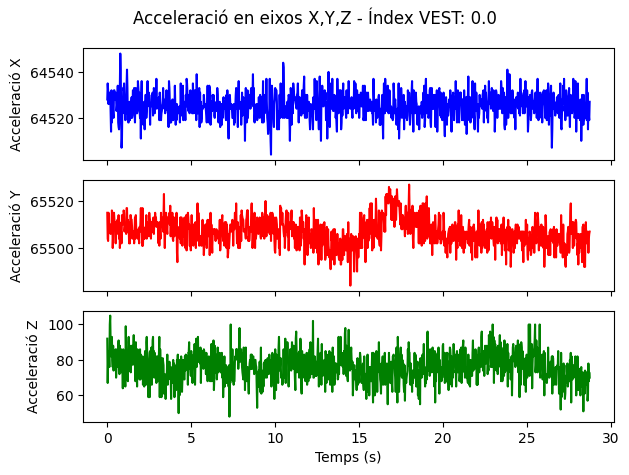

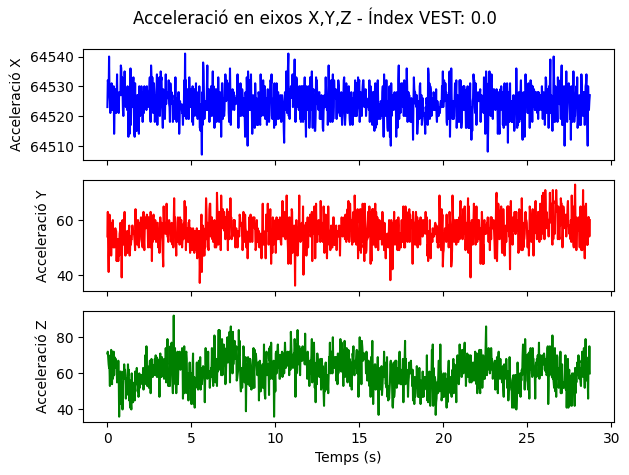

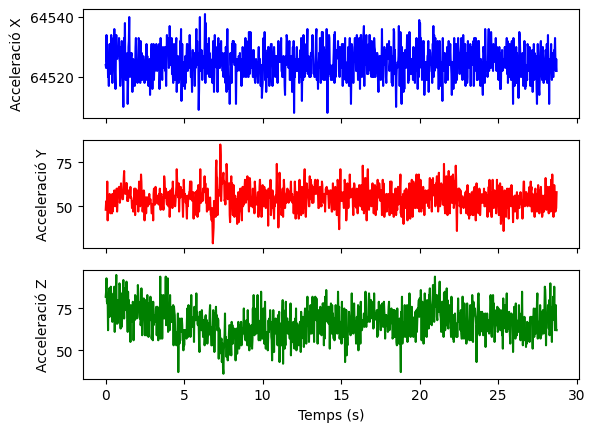

In [43]:
import matplotlib.pyplot as plt

Índex_VEST = dataROA['Indice_VEST'].astype(float)/100
label = Índex_VEST.astype(np.float32)
label = label.reset_index(drop=True)
label = label*100
len(label)

for i in range(X.shape[0]):
  tiempo = np.arange(0, 1150) * 0.025
  aceleracion_x = [int(elemento) for elemento in X.loc[i, 'acelerometro_x']]  # Valores de aceleración en el eje x
  aceleracion_y = [int(elemento) for elemento in X.loc[i, 'acelerometro_y']]  # Valores de aceleración en el eje y
  aceleracion_z =  [int(elemento) for elemento in X.loc[i, 'acelerometro_z']]  # Valores de aceleración en el eje z

  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

  ax1.plot(tiempo, aceleracion_x, color = 'blue')
  ax1.set_ylabel('Acceleració X')

  ax2.plot(tiempo, aceleracion_y,color='red')
  ax2.set_ylabel('Acceleració Y')

  ax3.plot(tiempo, aceleracion_z,color='green')
  ax3.set_xlabel('Temps (s)')
  ax3.set_ylabel('Acceleració Z')

  titol = 'Acceleració en eixos X,Y,Z - Índex VEST: {}'.format(label[i])
  fig.suptitle(titol)

  plt.tight_layout()

  nombre_archivo = "acc_{}.png".format(i)
  if label[i]<0.5:

    ruta_archivo = '/content/drive/My Drive/graf_acc/roa_pos/' + nombre_archivo
  else:

    ruta_archivo = '/content/drive/My Drive/graf_acc/roa_neg/' + nombre_archivo

  plt.savefig(ruta_archivo)

In [ ]:
X_3d = np.empty((X.shape[0], X.shape[1], len(X.values[0][0])), dtype=object)  # ndarray de forma (78, 12, 1150) con elementos vacíos
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        X_3d[i, j] = tf.constant(X.values[i][j])

In [ ]:
#funcio que redimensiona les dades a 2d per poder aplicar minmaxscaler, NORM PER CARACTERÍSTIQUES
class MinMaxScaler3D(MinMaxScaler):
    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

In [ ]:
scaler = MinMaxScaler3D()
X_3d = scaler.fit_transform(X_3d)

In [ ]:
X_train = X_3d[:90].astype(np.float32)
y_train = Índex_SOM[:90].astype(np.float32)
y_Train = y_train.values
X_test = X_3d[90:].astype(np.float32)
y_test = Índex_SOM[90:].astype(np.float32)
y_test = y_test.values
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(90, 12, 1150) (90,) (13, 12, 1150) (13,)


Començem per crear una LSTM per a les dades de l'accelerómetre

In [ ]:
accelerometre_train, accelerometre_test = X_train[:, :3, :], X_test[:, :3, :]
accelerometre_train = accelerometre_train.transpose((0, 2, 1))
accelerometre_test = accelerometre_test.transpose((0,2,1))
print(accelerometre_train.shape, accelerometre_test.shape)


(90, 1150, 3) (13, 1150, 3)


In [ ]:
giroscop_train, giroscop_test = X_train[:, 3:6, :], X_test[:, 3:6, :]
giroscop_train = giroscop_train.transpose((0, 2, 1))
giroscop_test = giroscop_test.transpose((0,2,1))
print(giroscop_train.shape, giroscop_test.shape)


(90, 1150, 3) (13, 1150, 3)


In [ ]:
compass_train, compass_test = X_train[:, 6:9, :], X_test[:, 6:9, :]
compass_train = compass_train.transpose((0, 2, 1))
compass_test = compass_test.transpose((0,2,1))
print(compass_train.shape, compass_test.shape)


(90, 1150, 3) (13, 1150, 3)


In [ ]:
gravity_train, gravity_test = X_train[:, 9:12, :], X_test[:, 9:12, :]
gravity_train = gravity_train.transpose((0, 2, 1))
gravity_test = gravity_test.transpose((0,2,1))
print(gravity_train.shape, gravity_test.shape)

(90, 1150, 3) (13, 1150, 3)


In [ ]:
# Construir el modelo de LSTM
model_acc = Sequential()
model_acc.add(LSTM(64, input_shape=(1150, 3)))
model_acc.add(Dropout(0.30))
model_acc.add(Dense(1, activation='sigmoid'))
"""
# Compilar y entrenar el modelo
model_acc.compile(loss='mean_squared_error', optimizer='adam')
model_acc.fit(accelerometre_train, y_train, epochs=10, batch_size=16)

# Evaluar el modelo en el conjunto de prueba
loss = model_acc.evaluate(accelerometre_test, y_test)
print(f'Loss en el conjunto de prueba: {loss}')"""

"\n# Compilar y entrenar el modelo\nmodel_acc.compile(loss='mean_squared_error', optimizer='adam')\nmodel_acc.fit(accelerometre_train, y_train, epochs=10, batch_size=16)\n\n# Evaluar el modelo en el conjunto de prueba\nloss = model_acc.evaluate(accelerometre_test, y_test)\nprint(f'Loss en el conjunto de prueba: {loss}')"

In [ ]:
# Construir el modelo de LSTM
model_gir = Sequential()
model_gir.add(LSTM(64, input_shape=(1150, 3)))
model_gir.add(Dropout(0.30))
model_gir.add(Dense(1, activation='sigmoid'))

In [ ]:
# Construir el modelo de LSTM
model_compass = Sequential()
model_compass.add(LSTM(64, input_shape=(1150, 3)))
model_compass.add(Dropout(0.30))
model_compass.add(Dense(1, activation='sigmoid'))

In [ ]:
# Construir el modelo de LSTM
model_grav = Sequential()
model_grav.add(LSTM(64, input_shape=(1150, 3)))
model_grav.add(Dropout(0.30))
model_grav.add(Dense(1, activation='sigmoid'))

In [ ]:
# Concatenar las salidas de las redes individuales
concatenated = Concatenate()([model_acc.output, model_gir.output, model_compass.output, model_grav.output])

# Capa densa final
dense = Dense(32, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense)

# Crear el modelo combinado
model_combined = Model(inputs=[model_acc.input, model_gir.input, model_compass.input, model_grav.input], outputs=output)


sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)


# Compilar y entrenar el modelo
model_combined.compile(loss='mean_squared_error', optimizer='adam')
model_combined.fit([accelerometre_train, giroscop_train, compass_train, gravity_train], y_train, sample_weight=sample_weights ,epochs=10, batch_size=32)

# Evaluar el modelo en los datos de prueba
loss = model_combined.evaluate([accelerometre_test, giroscop_test, compass_test, gravity_test], y_test)
print(f'Loss en los datos de prueba: {loss}')


Epoch 1/10
3/3 [==============================] - 17s 2s/step - loss: 0.1939
Epoch 2/10
3/3 [==============================] - 6s 2s/step - loss: 0.1787
Epoch 3/10
3/3 [==============================] - 6s 2s/step - loss: 0.1647
Epoch 4/10
3/3 [==============================] - 5s 2s/step - loss: 0.1502
Epoch 5/10
3/3 [==============================] - 7s 3s/step - loss: 0.1341
Epoch 6/10
3/3 [==============================] - 5s 2s/step - loss: 0.1139
Epoch 7/10
3/3 [==============================] - 5s 2s/step - loss: 0.1038
Epoch 8/10
3/3 [==============================] - 6s 2s/step - loss: 0.0957
Epoch 9/10
3/3 [==============================] - 5s 2s/step - loss: 0.0891
Epoch 10/10
1/1 [==============================] - 3s 3s/step - loss: 0.0975
Loss en los datos de prueba: 0.09747285395860672


In [ ]:
yhat = model_combined.predict([accelerometre_test, giroscop_test, compass_test, gravity_test])

1/1 [==============================] - 2s 2s/step


In [ ]:
for i in range(0,len(yhat)):
  print(yhat[i], y_test[i])

[0.68437755] 1.0
[0.6843775] 1.0
[0.68437475] 1.0
[0.6843748] 1.0
[0.6843424] 1.0
[0.6843425] 1.0
[0.684343] 0.9769745
[0.684343] 0.9769745
[0.6843462] 1.0
[0.6843462] 1.0
[0.6843774] 1.0
[0.6843774] 1.0
[0.68437725] 1.0
